In [21]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'monospace',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

In [22]:
regs = ['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5']

regdict = {'ARCTIC' : {'number' : 0.5},
           'P1' : {'number': 1.0},
          'P2' : {'number': 1.2},
           'P3' : {'number': 1.4},
           'P4' : {'number': 1.6},
           'P5' : {'number': 1.8},
            'A1' : {'number': 2.4},
          'A2' : {'number': 2.6},
           'A3' : {'number': 2.8},
           'A4' : {'number': 3},
           'A5' : {'number': 3.2},
           'I3' : {'number': 3.6},
           'I4' : {'number': 3.8},
           'I5' : {'number': 4},
           
          }

In [23]:
tics = []
tcm = 'Spectral'

In [24]:

tmask = nc.Dataset('/gpfs/data/greenocean/software/resources/breakdown/clq_basin_masks_ORCA.nc')

maskno = np.zeros([149,182])
for i in range(0, len(regs)):
    maskno[tmask[regs[i]][:] == 1] = regdict[regs[i]]['number']
    tics.append(regdict[regs[i]]['number'])
maskno[maskno == 0] = np.nan

In [25]:
def test_region_parsing():
    w = plt.pcolor(maskno, cmap = tcm, vmin = 0.5, vmax = 4)
    cbar = plt.colorbar(w, ticks=tics)
    t = cbar.ax.set_yticklabels(['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5'], fontsize = 9)
    plt.suptitle('ocean regions, subdivided')

    fact = 0.2
    fig = plt.figure(figsize=(30*fact,15*fact))
    import matplotlib
    cmap = matplotlib.cm.get_cmap('Spectral')
    norm = matplotlib.colors.Normalize(vmin=0.5, vmax=4)
    for i in range(0,len(regs)):
        rgba = cmap(norm(regdict[regs[i]]['number']))
        plt.plot(regdict[regs[i]]['number'], 1, marker = 'o', color = rgba, label = regs[i])
        regdict[regs[i]]['colour'] = rgba
    plt.legend(ncol = 5, fontsize = 10)
    plt.suptitle('colours assigned')

In [26]:
# test_region_parsing()

In [27]:
# maskno_broad = np.zeros([31,149,182])
# # tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')

# for i in range(0,31):
#     maskno_broad[i,:,:] = maskno

# 1 model, 1990-2020

In [28]:
import glob

def make_yearlist(yrst, yrend, dtype, tr, baseDir):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'{baseDir}/{tr}/ORCA2_1m_{yrs[i]}*{dtype}*.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

baseDir = '/gpfs/data/greenocean/software/runs/'
tr = 'TOM12_TJ_GEA0'
yrst = 1990
yrend = 2020
dtype = 'ptrc'
tylist = make_yearlist(yrst, yrend, dtype, tr, baseDir)
tdat_GEA0 = xr.open_mfdataset(tylist)
# tdat_GEA0

In [29]:
DIC0 = tdat_GEA0.DIC.isel(deptht=0)
TA0 = tdat_GEA0.Alkalini.isel(deptht=0)

In [30]:
mean_masks = np.zeros([len(regs), 149, 182])
for i, reg in enumerate(regs):
    mean_masks[i][maskno == regdict[reg]['number']] = 1

In [31]:
# DIC_mean = np.zeros([len(regs), len(DIC0), ])
# TA_mean = np.zeros([len(regs), len(TA0), ])
DIC_total_mean = np.zeros([len(regs)])
TA_total_mean = np.zeros([len(regs),])

for j in range(len(regs)):
    mask_data_array = xr.DataArray(mean_masks[j], dims=['y', 'x'])
    DIC_total_mean[j] = DIC0.weighted(mask_data_array).mean(dim = ['x','y', 'time_counter'])
    TA_total_mean[j] = TA0.weighted(mask_data_array).mean(dim = ['x','y', 'time_counter'])    

    # for time_i in range(len(DIC)):
    #     DIC_mean[j][time_i] = DIC[time_i].weighted(mask_data_array).mean(dim = ['x','y'])
    #     TA_mean[j][time_i] = TA[time_i].weighted(mask_data_array).mean(dim=['x', 'y'])

In [42]:
DIC0

DIC_tempmean = DIC0.mean(dim = ['time_counter'])
DIC_tempmean

<xarray.DataArray 'DIC' (y: 149, x: 182)>
dask.array<mean_agg-aggregate, shape=(149, 182), dtype=float32, chunksize=(149, 182), chunktype=numpy.ndarray>
Coordinates:
    nav_lat  (y, x) float32 dask.array<chunksize=(149, 182), meta=np.ndarray>
    nav_lon  (y, x) float32 dask.array<chunksize=(149, 182), meta=np.ndarray>
    deptht   float32 5.0
Dimensions without coordinates: y, x

In [32]:
import matplotlib
cmap = matplotlib.cm.get_cmap('Spectral')
norm = matplotlib.colors.Normalize(vmin=0.5, vmax=4)

    TA vs. DIC 

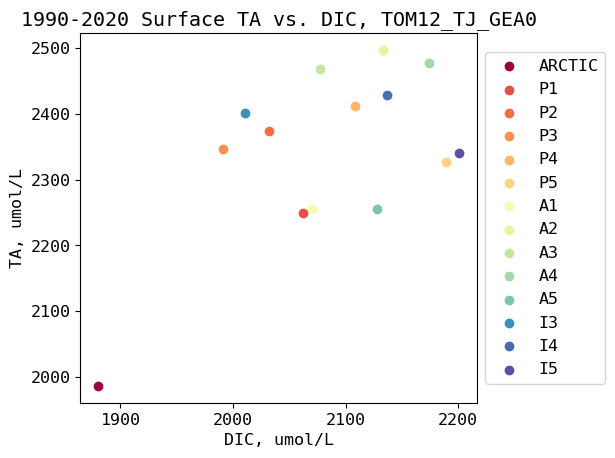

In [33]:

fig = plt.figure()
ax = plt.subplot(111)

for j, reg in enumerate(regs):
    plt.scatter(DIC_total_mean[j] * 1e6, TA_total_mean[j] * 1e6, label = f'{reg}', color=cmap(norm(regdict[reg]['number'])))

plt.title(f'{yrst}-{yrend} Surface TA vs. DIC, TOM12_TJ_GEA0')

plt.xlabel('DIC, umol/L')
plt.ylabel('TA, umol/L')
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

TA-DIC vs. DIC

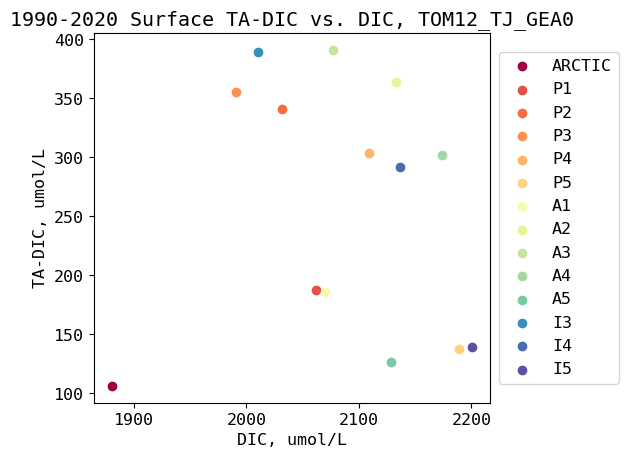

In [34]:
fig = plt.figure()
ax = plt.subplot(111)

for j, reg in enumerate(regs):
    plt.scatter(DIC_total_mean[j] * 1e6, (TA_total_mean[j]-DIC_total_mean[j]) * 1e6, label = f'{reg}', color=cmap(norm(regdict[reg]['number'])))

plt.title(f'{yrst}-{yrend} Surface TA-DIC vs. DIC, TOM12_TJ_GEA0')

plt.xlabel('DIC, umol/L')
plt.ylabel('TA-DIC, umol/L')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

# 3 models, 2015-2020,5 years

In [35]:
mean_masks = np.zeros([len(regs), 149, 182])
for i, reg in enumerate(regs):
    mean_masks[i][maskno == regdict[reg]['number']] = 1

In [36]:
baseDir = '/gpfs/data/greenocean/software/runs/'
yrst = 2015
yrend = 2020 
depth = 0
dtype = 'ptrc'
modlist = ['TOM12_TJ_GEA0', 'TOM12_DW_GA01','TOM12_DW_WE43']

data_mapping = {}

for modnam in modlist:
    tylist = make_yearlist(yrst, yrend, dtype, modnam, baseDir)
    tdat = xr.open_mfdataset(tylist)

    DIC0 = tdat.DIC.isel(deptht=depth)
    TA0 = tdat.Alkalini.isel(deptht=depth)
    # DIC_mean = np.zeros([len(regs), len(DIC0), ])
    # TA_mean = np.zeros([len(regs), len(TA0), ])
    DIC_total_mean = np.zeros([len(regs)])
    TA_total_mean = np.zeros([len(regs),])

    for j in range(len(regs)):
        mask_data_array = xr.DataArray(mean_masks[j], dims=['y', 'x'])
        DIC_total_mean[j] = DIC0.weighted(mask_data_array).mean(dim = ['x','y', 'time_counter'])
        TA_total_mean[j] = TA0.weighted(mask_data_array).mean(dim = ['x','y', 'time_counter'])

    data_mapping[modnam] = {'TA_total_mean':  TA_total_mean, 'DIC_total_mean':DIC_total_mean}
    

In [37]:
# data_mapping

    PLOTS

In [38]:
import matplotlib
cmap = matplotlib.cm.get_cmap('Spectral')
norm = matplotlib.colors.Normalize(vmin=0.5, vmax=4)

import matplotlib.lines as mlines
from matplotlib.legend import Legend


        - TA vs. DIC

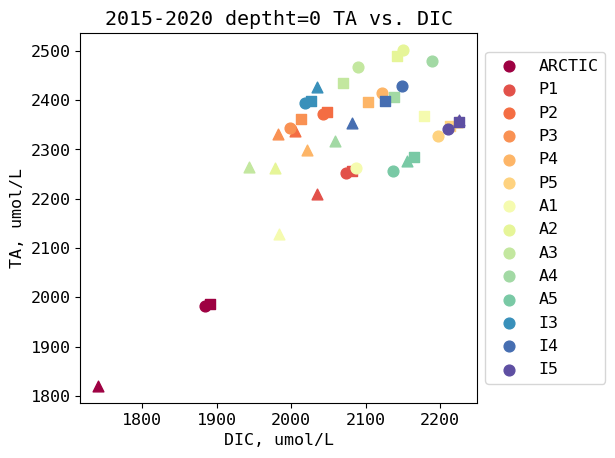

In [39]:

fig = plt.figure()
ax = plt.subplot(111)
msize = 60
# modlist = ['TOM12_TJ_GEA0', 'TOM12_DW_GA01','TOM12_DW_WE43']
# marker = ['o','^','s']
# for m, modam in enumerate(modlist):

for j, reg in enumerate(regs):
    plt.scatter(data_mapping['TOM12_TJ_GEA0']['DIC_total_mean'][j] * 1e6, 
                data_mapping['TOM12_TJ_GEA0']['TA_total_mean'][j] * 1e6, 
                marker= 'o' , s=msize,color=cmap(norm(regdict[reg]['number'])), label = f'{reg}') 
    plt.scatter(data_mapping['TOM12_DW_GA01']['DIC_total_mean'][j] * 1e6, 
                data_mapping['TOM12_DW_GA01']['TA_total_mean'][j] * 1e6, 
                marker= '^' , s=msize,color=cmap(norm(regdict[reg]['number']))) #label = f'{reg}'
    plt.scatter(data_mapping['TOM12_DW_WE43']['DIC_total_mean'][j] * 1e6, 
                data_mapping['TOM12_DW_WE43']['TA_total_mean'][j] * 1e6, 
                marker= 's' ,s=msize, color=cmap(norm(regdict[reg]['number']))) #label = f'{reg}'

plt.title(f'{yrst}-{yrend} deptht={depth} TA vs. DIC')

plt.xlabel('DIC, umol/L')
plt.ylabel('TA, umol/L')

# legend
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height]) # Shrink current axis by 20%
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # Put a legend to the right of the current axis

# curcle = mlines.Line2D([], [], color='k', marker='o', linestyle='None',
#                           markersize=10, label='TOM12_TJ_GEA0')
# triangle = mlines.Line2D([], [], color='k', marker='^', linestyle='None',
#                           markersize=10, label='TOM12_DW_GA01')
# square = mlines.Line2D([], [], color='k', marker='s', linestyle='None',
#                           markersize=10, label='TOM12_DW_WE43')
# plt.legend(handles=[curcle, triangle,square],loc='lower right', frameon=False)
# ax.add_artist(leg)

plt.show()

        -TA-DIC vs. DIC

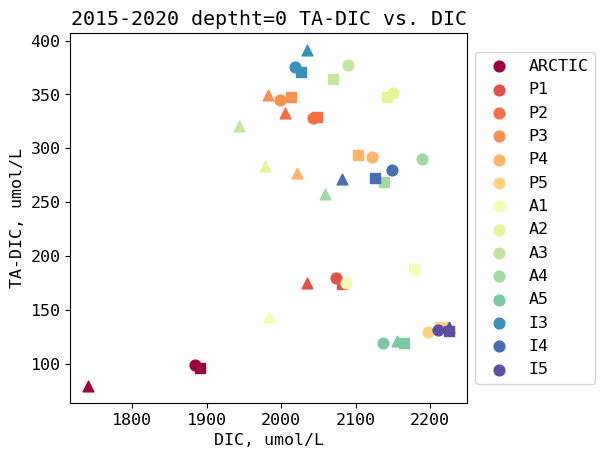

In [40]:
fig = plt.figure()
ax = plt.subplot(111)
msize = 60
# modlist = ['TOM12_TJ_GEA0', 'TOM12_DW_GA01','TOM12_DW_WE43']
# marker = ['o','^','s']
# for m, modam in enumerate(modlist):

for j, reg in enumerate(regs):
    plt.scatter(data_mapping['TOM12_TJ_GEA0']['DIC_total_mean'][j] * 1e6, 
                (data_mapping['TOM12_TJ_GEA0']['TA_total_mean'][j]- data_mapping['TOM12_TJ_GEA0']['DIC_total_mean'][j]) * 1e6, 
                marker= 'o' , s=msize,color=cmap(norm(regdict[reg]['number'])), label = f'{reg}') 
    plt.scatter(data_mapping['TOM12_DW_GA01']['DIC_total_mean'][j] * 1e6, 
                (data_mapping['TOM12_DW_GA01']['TA_total_mean'][j]- data_mapping['TOM12_DW_GA01']['DIC_total_mean'][j]) * 1e6, 
                marker= '^' , s=msize,color=cmap(norm(regdict[reg]['number']))) #label = f'{reg}'
    plt.scatter(data_mapping['TOM12_DW_WE43']['DIC_total_mean'][j] * 1e6, 
                (data_mapping['TOM12_DW_WE43']['TA_total_mean'][j]- data_mapping['TOM12_DW_WE43']['DIC_total_mean'][j]) * 1e6, 
                marker= 's' ,s=msize, color=cmap(norm(regdict[reg]['number']))) #label = f'{reg}'

plt.title(f'{yrst}-{yrend} deptht={depth} TA-DIC vs. DIC')

plt.xlabel('DIC, umol/L')
plt.ylabel('TA-DIC, umol/L')

# legend
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height]) # Shrink current axis by 20%
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # Put a legend to the right of the current axis